# ColorSkim Machine Learning AI



In [1]:
# import modul dasar⁡⁡
import os
import random
import gc #garbage collector
import io
# import pandas, numpy dan tensorflow⁡
import pandas as pd
import numpy as np
import tensorflow as tf

# import daftar device terdeteksi oleh tensorflow
from tensorflow.python.client.device_lib import list_local_devices

# import utilitas umum tensorflow
from tensorflow.config import run_functions_eagerly # type: ignore
from tensorflow.data.experimental import enable_debug_mode # type: ignore

# import pembuatan dataset
from sklearn.model_selection import train_test_split
"""
karena struktur objek dalam tf.data.Dataset, from_tensor_slices() 
dan zip tidak dapat dipanggil secara langsung dalam modul import
"""
from_tensor_slices = tf.data.Dataset.from_tensor_slices
zip = tf.data.Dataset.zip

# import preprocessing data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow_hub as hub


# import pipeline scikit untuk model_0
from sklearn.pipeline import Pipeline

# import layer neural network
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPooling1D, Bidirectional, LSTM, Dropout # type: ignore
from tensorflow.keras.layers import Concatenate # type: ignore
from tensorflow.keras.layers import TextVectorization # type: ignore
from tensorflow.keras.layers import Embedding # type: ignore

# import fungsi loss dan optimizer
from tensorflow.keras.losses import BinaryCrossentropy # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# import model Functional API tensorflow
from tensorflow.keras import Model # type: ignore

# import callbacks untuk tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # type: ignore

# import model terbaik, metriks dan alat evaluasi
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tensorflow.keras.models import load_model # type: ignore

# import grafik
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model # type: ignore
from scipy.stats import binned_statistic

# import display untuk menampilkan dataframe berdasar settingan tertentu (situasional)
from IPython.display import display

# import library log untuk training
import wandb as wb
from wandb.keras import WandbCallback

# import kunci untuk login wandb
from rahasia import API_KEY_WANDB # type: ignore

# set output tensorflow
run_functions_eagerly(True)
enable_debug_mode()

# set matplotlib untuk menggunakan tampilan seaborn
sns.set()

In [2]:
# cek ketersediaan GPU untuk modeling
# NVidia GeForce MX250 - office
# NVidia GeForce GTX1060 - home
list_local_devices()[1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1408103015
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4677246905546237580
physical_device_desc: "device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419

## Variabel Global

In [3]:
DIR_MODEL_CHECKPOINT = 'colorskim_checkpoint'
# kita akan mengatur toleransi_es sebagai fraksi (fraksi_toleransi) tertentu dari jumlah total epoch
# dan toleransi_rlop sebagai toleransi_es dibagi dengan jumlah kesempatan (kesempatan_rlop)
# dilakukannya reduksi pada learning_rate 
EPOCHS = 1000
UKURAN_BATCH = 32
FRAKSI_TOLERANSI = 0.01
KESEMPATAN_RLOP = 5
TOLERANSI_ES = int(EPOCHS*FRAKSI_TOLERANSI)
TOLERANSI_RLOP = int(TOLERANSI_ES/KESEMPATAN_RLOP)
FRAKSI_REDUKSI_LR = 0.1
METRIK_MONITOR = 'val_accuracy'
RANDOM_STATE = 11
# untuk mencegah overfitting, kita akan memberikan ruang yang cukup besar 
# untuk test_data dan memperkecil porsi train_data dengan jumlah epoch
# yang besar sehingga model masih memiliki waktu untuk melakukan
# training pada train_data
RASIO_TEST_TRAIN = 0.2

# wandb init
wandb = {'proyek': 'ColorSkim',
         'user': 'jpao'}

# nama model
MODEL = ['model_0_multinomial_naive_bayes',
         'model_1_Conv1D_vektorisasi_embedding',
         'model_2_Conv1D_USE_embed',
         'model_3_quadbrid_embedding']

## Callbacks

Beberapa *callbacks* yang akan digunakan dalam proses *training* model diantaranya:

* `WandbCallback` - *Callback* ke [wandb.ai](https://wandb.ai) untuk mencatat log dari sesi *training* model.
* `ModelCheckpoint` - Untuk menyimpan model dengan *val_accuracy* terbaik dari seluruh *epoch* dalam *training* model.
* `EarlyStopping` (ES) - *Callback* ini digunakan untuk menghentikan proses *training* model jika selama beberapa *epoch* model tidak mengalami perbaikan pada metrik *val_accuracy*-nya. *Callback* ini juga digunakan bersama dengan `ReduceLROnPlateau` dimana *patience* ES > *patience* RLOP.
* `ReduceLROnPlateau` (RLOP) - *Callback* ini digunakan untuk memperkecil *learning_rate* dari model jika tidak mengalami perbaikan *val_accuracy* selama beberapa *epoch*.

*Patience* dari ES di-set lebih tinggi dari *patience* RLOP untuk memberikan kesempatan bagi RLOP untuk memperkecil *learning_rate* beberapa kali sebelum proses *training* model dihentikan oleh ES setelah tidak berhasil mendapatkan *val_accuracy* yang lebih baik selama beberapa *epoch*.

In [4]:

# Login ke wandb
wb.login(key=API_KEY_WANDB)

# Pembuatan fungsi callback
def wandb_callback(data_training):
    return WandbCallback(save_model=False, # model akan disimpan menggunakan callback ModelCheckpoint
                         log_weights=True, # bobot akan disimpan untuk visualisasi di wandb
                         log_gradients=True, # gradient akan disimpan untuk visualisasi di wandb
                         training_data=data_training) 
def model_checkpoint(nama_model):
    return ModelCheckpoint(filepath=os.path.join(DIR_MODEL_CHECKPOINT, nama_model),
                           verbose=0,
                           monitor=METRIK_MONITOR,
                           save_best_only=True) # model dengan 'val_accuracy' terbaik akan disimpan
def early_stopping():
    return EarlyStopping(patience=TOLERANSI_ES,
                         monitor=METRIK_MONITOR)
def reduce_lr_on_plateau():
    return ReduceLROnPlateau(factor=FRAKSI_REDUKSI_LR, # pengurangan learning_rate diset sebesar 0.1 * learning_rate
                             patience=TOLERANSI_RLOP,
                             monitor=METRIK_MONITOR,
                             verbose=0)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jpao (pri-data). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\jPao/.netrc


## Data

Data yang dipergunakan adalah sebanyak 101,077 kata. Terdapat 2 versi data, data versi 1 hanya memiliki 56,751 kata dan data versi 2 adalah data lengkap.

* Data 1: 56,751 kata, terdiri dari 34,174 kata dengan label `bukan_warna` dan 22,577 kata dengan label `warna` atau rasio 1.51 : 1 `bukan_warna` berbanding `warna`
* Data 2: 101,077 kata, dikarenakan kekurangan *man power* untuk proses *labeling* manual, maka kita tidak akan menggunakan data ini.

`brand`, `urut_kata` dan `total_kata` akan digunakan sebagai alternatif variabel independen tambahan dalam model tertentu.

In [32]:
""" 
Membaca data ke dalam DataFrame pandas
Merubah kolom `urut_kata` dan 'total_kata' menjadi float32
"""
data = pd.read_csv('data/setengah_dataset_artikel.csv')
data = data.astype({'urut_kata': np.float32, 'total_kata': np.float32})
# Untuk dokumentasi, gunakan format markdown untuk rendering dataframe
# Menampilkan 100 data pertama
print(data[:100].to_markdown())

|    | brand   | nama_artikel                       | kata       | label       |   urut_kata |   total_kata |
|---:|:--------|:-----------------------------------|:-----------|:------------|------------:|-------------:|
|  0 | ADI     | ADISSAGE-BLACK/BLACK/RUNWHT        | ADISSAGE   | bukan_warna |           1 |            4 |
|  1 | ADI     | ADISSAGE-BLACK/BLACK/RUNWHT        | BLACK      | warna       |           2 |            4 |
|  2 | ADI     | ADISSAGE-BLACK/BLACK/RUNWHT        | BLACK      | warna       |           3 |            4 |
|  3 | ADI     | ADISSAGE-BLACK/BLACK/RUNWHT        | RUNWHT     | warna       |           4 |            4 |
|  4 | ADI     | ADISSAGE-N.NAVY/N.NAVY/RUNWHT      | ADISSAGE   | bukan_warna |           1 |            4 |
|  5 | ADI     | ADISSAGE-N.NAVY/N.NAVY/RUNWHT      | N.NAVY     | warna       |           2 |            4 |
|  6 | ADI     | ADISSAGE-N.NAVY/N.NAVY/RUNWHT      | N.NAVY     | warna       |           3 |            4 |
|  7 | ADI

### Eksplorasi Data

bukan_warna    34174
warna          22577
Name: label, dtype: int64


<Figure size 432x288 with 0 Axes>

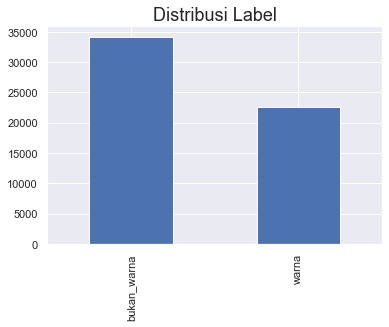

<Figure size 432x288 with 0 Axes>

In [35]:
# distribusi label dalam data
print(data['label'].value_counts())
data['label'].value_counts().plot(kind='bar')
plt.gca().set_title('Distribusi Label', fontsize=18)
plt.figure(facecolor='w')

label  bukan_warna    warna
brand                      
NIK        13396.0  10807.0
ADI        10028.0   7073.0
PUM         4279.0   2062.0
BBC         1174.0    367.0
CAO          887.0     61.0
HER          868.0    287.0
AGL          611.0    212.0
KIP          554.0    321.0
STN          494.0    255.0
WAR          404.0    298.0


<Figure size 432x288 with 0 Axes>

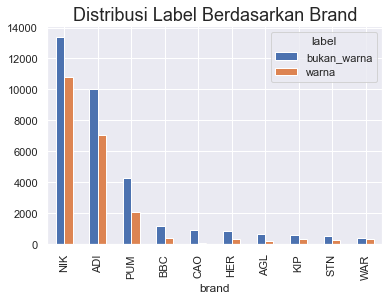

<Figure size 432x288 with 0 Axes>

In [36]:
# distribusi label dalam brand (data hanya menunjukkan 10 teratas)
print(data[['brand', 'label']].value_counts().unstack().sort_values(by='bukan_warna', ascending=False)[:10])
data[['brand', 'label']].value_counts().unstack().sort_values(by='bukan_warna', ascending=False)[:10].plot(kind='bar')
plt.gca().set_title('Distribusi Label Berdasarkan Brand', fontsize=18)
plt.figure(facecolor='w')

### Konversi Fitur dan Label ke dalam numerik

Kita akan melakukan pengkonversian fitur dan label ke dalam bentuk numerik, dikarenakan jaringan saraf tiruan hanya dapat bekerja dalam data numerik. 

Terdapat dua jenis *encoding* untuk data yang bersifat kategorikal:

* `OneHotEncoder`
* `LabelEncoder`

**OneHotEncoder**
*Encoding* ini akan merubah data satu kolom menjadi multi-kolom dengan nilai 1 dan 0 dimana jumlah kolom sama dengan jumlah kategori, seperti berikut:

| brand | brand_NIK | brand_ADI | brand_SPE | brand_PIE | brand_... |
| --- | --- | --- | --- | --- | --- |
| NIK | 1 | 0 | 0 | 0 | ... |
| SPE | 0 | 0 | 1 | 0 | ... |
| PIE | 0 | 0 | 0 | 1 | ... |
| ADI | 0 | 1 | 0 | 0 | ... |
| SPE | 0 | 0 | 1 | 0 | ... |
| ... | ... | ... | ... | ... | ... |

**LabelEncoder**
*Encoding* ini akan merubah data pada satu kolom menjadi 0, 1, 2, 3.. dstnya sesuai dengan jumlah kategorinya, seperti berikut:

| brand | brand_label_encoded |
| --- | --- |
| NIK | 0 |
| SPE | 1 |
| PIE | 2 |
| ADI | 3 |
| SPE | 1 |
| ... | ... |

**Kapan menggunakan `OneHotEncoder` atau `LabelEncoder` dalam sebuah proses encoding?** Kita dapat menggunakan `OneHotEncoder` ketika kita tidak menginginkan suatu bentuk hubungan hirarki di dalam data kategorikal yang kita miliki. Dalam hal ini ketika kita tidak ingin jaringan saraf tiruan untuk memandang ADI (3) lebih signifikan dari NIK (0) dalam hal nilainya jika dilakukan label *encoding*, maka kita dapat menggunakan `OneHotEncoder`.
Jika kategori bersifat biner seperti 'Pria' atau 'Wanita', 'Ya' atau 'Tidak' dsbnya, penggunaan `LabelEncoder` dinilai lebih efektif.

> Dengan pertimbangan di atas dan melihat struktur data kita, maka kita akan menggunakan `OneHotEncoder` untuk kolom *brand* (fitur) dan menggunakan `LabelEncoder` untuk kolom *label* (target), kecuali untuk **Model 0** yang akan menggunakan fungsi ekstraksi fitur dengan `TfIdfVectorizer` kita hanya akan menggunakan kolom 'label' yang belum di-*encode*.

In [15]:
# OneHotEncoding pada fitur brand
fitur_encoder = OneHotEncoder(sparse=False)
brand_encoded = fitur_encoder.fit_transform(data['brand'].to_numpy().reshape(-1, 1))
df_fitur_encoded = pd.DataFrame(brand_encoded, columns=fitur_encoder.get_feature_names_out(['brand']))

# LabelEncoding pada target label
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(data['label'])
df_label_encoded = pd.DataFrame(label_encoded, columns=['label_encoded'])

# gabungkan dengan dataframe awal
data_encoded = data.copy()
data_encoded = pd.concat([data_encoded,df_fitur_encoded, df_label_encoded], axis=1)
# Menampilkan 100 data pertama
print(data_encoded[:100].to_markdown())

|    | brand   | nama_artikel                       | kata       | label       |   urut_kata |   total_kata |   brand_ADI |   brand_ADS |   brand_AGL |   brand_AND |   brand_ASC |   brand_BAL |   brand_BBC |   brand_BEA |   brand_CAO |   brand_CIT |   brand_CRP |   brand_DOM |   brand_FIS |   brand_GUE |   brand_HER |   brand_JAS |   brand_KIP |   brand_NEW |   brand_NFA |   brand_NFC |   brand_NFL |   brand_NIB |   brand_NIC |   brand_NIK |   brand_NPS |   brand_ODD |   brand_PBY |   brand_PSB |   brand_PTG |   brand_PUM |   brand_REL |   brand_SAU |   brand_SOC |   brand_STN |   brand_UME |   brand_VAP |   brand_WAR |   label_encoded |
|---:|:--------|:-----------------------------------|:-----------|:------------|------------:|-------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|-------

### Konversi Data ke dalam Train dan Test untuk Model 0

Data akan dibagi ke dalam train dan test data menggunakan metode `train_test_split` dari modul *sklearn.model_selection* dengan menggunakan rasio dan keacakan yang telah ditentukan di variabel global (*RASIO_TEST_TRAIN* dan *RANDOM_STATE*).

In [102]:
# Menyimpan header data
data_header = data_encoded[['kata', 'brand', 'urut_kata', 'total_kata', 'label']].columns

"""
Model 0 adalah MultinomialNB yang akan menggunakan feature_extraction TfIdfVectorizer
dimana TfIdfVectorizer hanya dapat menerima satu kolom data yang akan diubah menjadi vector
(angka), kecuali kita dapat menggabungkan kembali brand kata dan kolom kolom lainnya ke dalam
satu kolom seperti['NIK GREEN 1 0 0 0 1'] alih - alih [['NIK', 'GREEN', '1', '0', '0', '0', '1']]
Maka untuk Model 0 kita tetap akan hanya menggunakan kolom 'kata' sebagai fitur.
kolom 'nama_artikel', 'brand', 'urut_kata' 'total_kata' dan 'label' sebenarnya tidak akan 
digunakan untuk training, namun pada train_test_split ini kita akan menyimpan brand untuk 
display hasil prediksi berbanding dengan target label (ground truth)
"""
train_data_mnb, test_data_mnb, train_target_mnb, test_target_mnb = train_test_split(data_encoded[['kata', 'nama_artikel', 'brand', 'urut_kata', 'total_kata', 'label']],
                                                                                    data_encoded['label_encoded'],
                                                                                    test_size=RASIO_TEST_TRAIN,
                                                                                    random_state=RANDOM_STATE)

# Untuk model lainnya kita akan menggunakan semua fitur minus 'brand', 'nama_artikel', 'label' dan 'label_encoded' .drop
train_data, test_data, train_target, test_target = train_test_split(data_encoded.drop(['brand', 'nama_artikel', 'label', 'label_encoded'], axis=1),
                                                                    data_encoded['label_encoded'],
                                                                    test_size=RASIO_TEST_TRAIN,
                                                                    random_state=RANDOM_STATE)

In [103]:
# Shape dari train_data_mnb, test_data_mnb, train_target_mnb dan test_target_mnb
train_data_mnb.shape, test_data_mnb.shape, train_target_mnb.shape, test_target_mnb.shape

((45400, 6), (11351, 6), (45400,), (11351,))

In [104]:
# Shape dari train_data, test_data, train_target dan test_target
train_data.shape, test_data.shape, train_target.shape, test_target.shape

((45400, 40), (11351, 40), (45400,), (11351,))

In [111]:
# Eksplorasi contoh hasil split train dan test
train_target_unik, train_target_hitung = np.unique(train_target_mnb, return_counts=True)
test_target_unik, test_target_hitung = np.unique(test_target_mnb, return_counts=True)
print('2 data pertama di train_data_mnb:')
with pd.option_context('display.max_columns', None):
    print(train_data_mnb.iloc[:2].to_markdown())
print('2 data pertama di train_data:')
with pd.option_context('display.max_columns', None):
    print(train_data[:2].to_markdown())
print('\n2 data pertama di train_target (mnb & non-mnb, sama):')
with pd.option_context('display.max_columns', None):
    print(train_target[:2].to_markdown()) 
print('2 data pertama di test_data_mnb:')
with pd.option_context('display.max_columns', None):
    print(test_data_mnb.iloc[:2].to_markdown())
print('2 data pertama di test_data:')
with pd.option_context('display.max_columns', None):
    print(test_data[:2].to_markdown())
print('2 data pertama di test_target (mnb & non-mnb, sama):')
with pd.option_context('display.max_columns', None):
    print(test_target[:2].to_markdown())
train_target_distribusi = np.column_stack((train_target_unik, train_target_hitung))
test_target_distribusi = np.column_stack((test_target_unik, test_target_hitung))
print(f'Distribusi label (target) di train: \n{train_target_distribusi}\n')
print(f'Distribusi label (target) di test: \n{test_target_distribusi}\n')
print('Dimana label 0 = bukan warna dan label 1 = warna')

2 data pertama di train_data_mnb:
|       | kata   | nama_artikel                                          | brand   |   urut_kata |   total_kata | label   |
|------:|:-------|:------------------------------------------------------|:--------|------------:|-------------:|:--------|
| 43886 | GREY   | AS W NK DRY TANK DFC YOGA FOIL-BARELY ROSE/SMOKE GREY | NIK     |          12 |           12 | warna   |
| 14859 | BLACK  | PRED SG CLB-BLACK                                     | ADI     |           4 |            4 | warna   |
2 data pertama di train_data:
|       | kata   |   urut_kata |   total_kata |   brand_ADI |   brand_ADS |   brand_AGL |   brand_AND |   brand_ASC |   brand_BAL |   brand_BBC |   brand_BEA |   brand_CAO |   brand_CIT |   brand_CRP |   brand_DOM |   brand_FIS |   brand_GUE |   brand_HER |   brand_JAS |   brand_KIP |   brand_NEW |   brand_NFA |   brand_NFC |   brand_NFL |   brand_NIB |   brand_NIC |   brand_NIK |   brand_NPS |   brand_ODD |   brand_PBY |   brand_PSB | 

## Model 0: Model Dasar

Model pertama yang akan kita buat adalah model *Multinomial Naive-Bayes* yang akan mengkategorisasikan *input* ke dalam kategori *output*. *Multinomial Naive-Bayes* adalah sebuah algoritma dengan metode *supervised learning* yang paling umum digunakan dalam pengkategorisasian data tekstual.
Pada dasarnya *Naive-Bayes* merupakan algoritma yang menghitung probabilitas dari sebuah event (*output*) berdasarkan probabilitas akumulatif kejadian dari event sebelumnya. Secara singkat algoritma ini akan mempelajari berapa probabilitas dari sebuah kata, misalkan 'ADISSAGE' adalah sebuah label `bukan_warna` berdasarkan probabilitas kejadian 'ADISSAGE' adalah `bukan_warna` pada event - event sebelumnya.

Formula dari probabilitias algoritma *Naive-Bayes*:

$P(A|B) = \frac{P(A) * P(B|A)}{P(B)}$

Sebelum melakukan training menggunakan algoritma *Multinomial Naive-Bayes* kita perlu untuk merubah data kata menjadi bentuk numerik yang kali ini akan dikonversi menggunakan metode TF-IDF (*Term Frequency-Inverse Document Frequency*). TF-IDF sendiri merupakan metode yang akan berusaha memvaluasi nilai relevansi dan frekuensi dari sebuah kata dalam sekumpulan dokumen. *Term Frequency* merujuk pada seberapa sering sebuah kata muncul dalam 1 dokumen, sedangkan *Inverse Document Frequency* adalah perhitungan logaritma dari jumlah seluruh dokumen dibagi dengan jumlah dokumen dengan kata yang dimaksud terdapat di dalamnya. Hasil perhitungan dari TF dan IDF ini akan dikalikan untuk mendapatkan nilai dari seberapa sering dan seberapa relevan nilai dari sebuah kata. Misalkan 'ADISSAGE' sering muncul dalam 1 dokumen tapi tidak terlalu banyak muncul di dokumen - dokumen lainnya, maka hal ini dapat mengindikasikan bahwa kata 'ADISSAGE' mungkin memiliki relevansi yang tinggi dalam kategorisasi sebuah dokumen, sebaliknya jika kata 'WHITE' sering muncul di 1 dokumen dan juga sering muncul di dokumen - dokumen lainnya, maka kata 'WHITE' ini mungkin merupakan sebuah kata yang umum dan memiliki nilai relevansi yang rendah dalam pengkategorisasian sebuah dokumen.

Untuk lebih lengkapnya mengenai *Naive-Bayes* dan TF-IDF dapat merujuk pada sumber berikut:

* https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c
* https://monkeylearn.com/blog/what-is-tf-idf/


In [112]:
# Membuat pipeline untuk mengubah kata ke dalam tf-idf
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit pipeline dengan data training
model_0.fit(X=np.squeeze(train_data_mnb.iloc[:, 0]), y=train_target_mnb)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [113]:
# Evaluasi model_0 pada data test
skor_model_0 = model_0.score(X=np.squeeze(test_data_mnb.iloc[:, 0]), y=test_target_mnb)
skor_model_0

0.9921592811206061

### Eksplorasi Hasil Model 0
Pada hasil training dengan menggunakan model algoritma *Multinomial Naive-Bayes* kita mendapatkan akurasi sebesar ~99.22%

Secara sekilas model yang pertama ini (model_0) memberikan akurasi yang sangat tinggi dalam membedakan kata `warna` dan `bukan_warna`. Namun secara brand spesifik, akurasi ini mungkin akan lebih buruk karena di beberapa brand terutama 'PUM' kita dapat menjumpai artikel dengan nama misalkan 'PUMA XTG WOVEN PANTS PUMA BLACK-PUMA WHITE' dimana kata PUMA pertama adalah `bukan_warna` namun kata PUMA kedua dan ketiga adalah bagian dari `warna`.

Dengan demikian, nanti kita mungkin akan mengulas lebih mendalam model pertama ini menggunakan dataset yang dipisahkan berdasar brand. Untuk sementara kita akan melanjutkan mengembangkan model - model alternatif untuk pemisahan `bukan_warna` dan `warna` dari nama artikel.

In [114]:
# Membuat prediksi menggunakan data test
model_0_pred = model_0.predict(np.squeeze(test_data_mnb.iloc[:, 0]))
model_0_pred

array([1, 0, 1, ..., 0, 0, 0])

In [27]:
# Membuat fungsi dasar untuk menghitung accuray, precision, recall, f1-score
def hitung_metrik(target, prediksi):
    """
    Menghitung akurasi, presisi, recall dan f1-score dari model klasifikasi biner
    
    Args:
        target: label yang sebenarnya dalam bentuk 1D array
        prediksi: label yang diprediksi dalam bentuk 1D array
        
    Returns:
        nilai accuracy, precision, recall dan f1-score dalam bentuk dictionary
    """
    # Menghitung akurasi model
    model_akurasi = accuracy_score(target, prediksi)
    # Menghitung precision, recall, f1-score dan support dari model
    model_presisi, model_recall, model_f1, _ = precision_recall_fscore_support(target, prediksi, average='weighted')
    
    hasil_model = {'akurasi': model_akurasi,
                   'presisi': model_presisi,
                   'recall': model_recall,
                   'f1-score': model_f1}
    
    return hasil_model

In [115]:
# Menghitung metrik dari model_0
model_0_metrik = hitung_metrik(target=test_target_mnb, 
                               prediksi=model_0_pred)
model_0_metrik

{'akurasi': 0.9921592811206061,
 'presisi': 0.9921602131872556,
 'recall': 0.9921592811206061,
 'f1-score': 0.9921562044603152}

**Akurasi** merupakan metrik yang menghitung jumlah prediksi yang benar dibanding total jumlah label yang dijadikan evaluasi (test data, bukan training data).

$\frac{\text{prediksi benar}}{\text{total prediksi}}$

**Presisi** merupakan metrik yang menghitung *true positive* berbanding dengan *true positive* dan *false positive*

$\frac{\text{true positive}}{\text{true positive } + \text{ false positive}}$

**Recall** merupakan metrik yang menghitung *true positive* berbanding dengan *true positive* dan *false negative*

$\frac{\text{true positive}}{\text{true positive } + \text{ false negative}}$

**f1-score** merupakan metrik yang mengabungkan presisi dan recall

$2 * \frac{\text{presisi } * \text{ recall}}{\text{presisi } + \text{ recall}}$

Dimana:

* True Positive (TP): Prediksi `warna` pada target label `warna`
* False Positive (FP): Prediksi `warna` pada target label `bukan_warna`
* True Negative (TN): Prediksi `bukan_warna` pada target label `bukan_warna`
* False Negative (FN): Prediksi `bukan_warna` pada target label `warna`

In [116]:
# Membuat fungsi untuk menampilkan confusion matrix
def plot_conf_matrix(target_label, 
                     prediksi_label, 
                     nama_model,
                     akurasi, 
                     label_titik_x, 
                     label_titik_y):
    """
    Fungsi ini akan menampilkan matrix confusion untuk perbandingan
    target label dan prediksi label dan memahami seberapa kesulitan
    sebuah model melakukan prediksi
    
    Args:
        target_label (list atau 1D-array): label yang sebenarnya dalam bentuk 1D array
        prediksi_label (list atau 1D-array): label yang diprediksi dalam bentuk 1D array
        akurasi (float): akurasi model dalam bentuk float
        label_titik_x (list str): label untuk x-axis dalam bentuk list
        label_titik_y (list str): label untuk y-axis dalam bentuk list
        
        label_titik_x dan label_titik_y, keduanya merupakan list dari sekumpulan
        string dan harus dalam bentuk vektor yang sama
        
    Returns:
        plot_confusion_matrix
    """
    # Membuat confusion matrix
    cf_matrix = confusion_matrix(target_label,
                                 prediksi_label)
    # Pengaturan confusion_matrix menggunakan seaborn
    plot_confusion_matrix = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
    plot_confusion_matrix.set_title(f'Confusion Matrix\n{nama_model}\nAkurasi {akurasi:.2%}', fontsize=18)
    plot_confusion_matrix.set_xlabel('Prediksi Label')
    plot_confusion_matrix.set_ylabel('Target Label')
    plot_confusion_matrix.xaxis.set_ticklabels(label_titik_x)
    plot_confusion_matrix.yaxis.set_ticklabels(label_titik_y)
    
    return plot_confusion_matrix

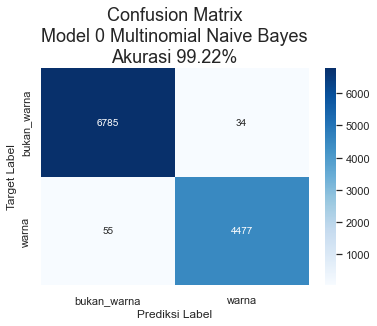

<Figure size 432x288 with 0 Axes>

In [117]:
# Menampilkan confusion matrix untuk model_0
plot_conf_matrix(target_label=test_target_mnb,
                 prediksi_label=model_0_pred,
                 nama_model='Model 0 Multinomial Naive Bayes',
                 akurasi=model_0_metrik['akurasi'],
                 label_titik_x=['bukan_warna', 'warna'],
                 label_titik_y=['bukan_warna', 'warna'])
plt.figure(facecolor='w')
plt.show()

Pada tabel *Confusion Matrix* di atas kita dapat melihat bahwa Model 0 berhasil memprediksi secara tepat 6,785 kata dengan label `bukan_warna` dan 4,477 kata dengan label `warna`.

Terdapat setidaknya 55 kata yang merupakan `warna` namun diprediksi oleh Model 0 sebagai `bukan_warna` dan 34 kata yang merupakan `bukan_warna` namun diprediksi oleh Model 0 sebagai `warna`

In [130]:
# Membuat fungsi untuk menampilkan kesalahan model dalam dataframe
def df_kesalahan_prediksi(label_encoder, 
                          test_data, 
                          prediksi, 
                          probabilitas_prediksi=None, 
                          order_ulang_header=None):
    """
    Fungsi ini akan menerima objek label encoder sklearn, set test_data
    sebelum modifikasi encoding fitur dan label, prediksi dari model
    serta urutan order_ulang_header jika diperlukan
    
    Args:
        label_encoder (obyek LabelEncoder sklear.preprocessing): obyek label encoder dari sklearn.preprocessing
        test_data (pd.DataFrame): dataframe lengkap sebelum modifikasi fitur dan label
        prediksi (tf.Tensor): tensor dengan shape 1 dimensi yang memuat prediksi model
        order_ulang_header (list): list dengan urutan header yang diinginkan
        
    Returns:
        pd.DataFrame yang diprint dengan format markdown
    """
    inverse_label_encoder = list(label_encoder.inverse_transform([0, 1]))
    
    if order_ulang_header is None:
        data_final = pd.DataFrame(test_data)
    elif type(order_ulang_header) is list:
        data_final = pd.DataFrame(test_data)[order_ulang_header]
    else:
        raise TypeError('order_ulang_header harus berupa list')
    
    kolom_pred = pd.DataFrame(np.int8(prediksi), columns=['prediksi'])
    kolom_prob_pred = pd.DataFrame(probabilitas_prediksi, columns=['probabilitas']) * 100
    data_final['prediksi'] = kolom_pred.iloc[:, 0].tolist()
    
    if probabilitas_prediksi is not None:
        data_final['probabilitas'] = kolom_prob_pred.iloc[:, 0].tolist()
        
    data_final['prediksi'] = data_final['prediksi'].astype(int).map(lambda x: inverse_label_encoder[x])
    
    if probabilitas_prediksi is not None:
        data_final = data_final.loc[data_final['label'] != data_final['prediksi']].sort_values(by='probabilitas', ascending=False)
        data_final['probabilitas'] = data_final['probabilitas'].round(2).astype(str) + '%'
    else:
        data_final = data_final.loc[data_final['label'] != data_final['prediksi']].sort_values(by='prediksi', ascending=False)
        
    with pd.option_context('display.max_rows', None):
        print(data_final.to_markdown())

In [131]:
# Menampilkan kesalahan prediksi 
df_kesalahan_prediksi(label_encoder=label_encoder,
                      test_data=test_data_mnb,
                      prediksi=model_0_pred,
                      order_ulang_header=['brand', 
                                          'nama_artikel',
                                          'kata', 
                                          'urut_kata', 
                                          'total_kata', 
                                          'label'])

|       | brand   | nama_artikel                                                | kata        |   urut_kata |   total_kata | label       | prediksi    |
|------:|:--------|:------------------------------------------------------------|:------------|------------:|-------------:|:------------|:------------|
| 19265 | BBC     | BB DARK STAR LS KNIT-BLACK                                  | DARK        |           2 |            6 | bukan_warna | warna       |
|  8962 | ADI     | LIN CORE ORG-BLACK                                          | CORE        |           2 |            4 | bukan_warna | warna       |
| 56086 | WAR     | FLAT GLOW IN THE DARK-WHITE                                 | GLOW        |           2 |            6 | bukan_warna | warna       |
| 16288 | ADI     | CLR BLK CRW 2PP-BLACK                                       | BLK         |           2 |            5 | bukan_warna | warna       |
| 52109 | PUM     | CELL STELLAR GLOW WNS PUMA WHITE-PURPLE                     | 

## Model 1: Conv1D dengan Embedding

`Conv1D` atau konvolusi 1 dimensi merupakan satu jenis layer dari layer convolution yang umumnya digunakan untuk mengekstrak fitur penting dari input data.

Meskipun umumnya jaringan saraf tiruan *convolution* digunakan untuk klasifikasi gambar (`Conv2D`) pada pembelajaran *image recognition*, tidak jarang juga `Conv1D` dipergunakan dalam *natural language processing* atau *time series forecasting*.

Layer ini pada prinsipnya menggunakan *kernel_size*, *padding* dan juga *stride* untuk menciptakan sebuah jendela yang akan men-*scan* input matrix atau vektor secara perlahan dan melakukan *pooling* (*min*, *max* atau *average pooling*) untuk mengekstrak nilai yang menjadi fitur penting dari input data.

Oleh karena itu layer *convolutional* ini sering dipergunakan dalam data yang sifatnya *sequence-to-sequence* atau *seq2seq* seperti dalam kasus *natural language processing*, *image classification/recognition*, *audio/video recognition* dan *time series forecasting*.

![convlayer](images/convlayer.gif)

*contoh `Conv2D` pada jaringan saraf tiruan untuk klasifikasi biner/multiclass dari input gambar*

Lebih lanjut mengenai jaringan saraf tiruan *convolution* (convolutional neural network) dapat merujuk pada [CNN Explainer](https://poloclub.github.io/cnn-explainer/)

### Vektorisasi dan Embedding Kata

#### Membuat Lapisan Vektorisasi Kata

Vektorisasi sebenarnya merupakan proses yang cukup sederhana yang merubah kata menjadi representasi numerik berdasarkan total jumlah kata dalam *vocabulary* dari input data.

Di lapisan vektorisasi ini sebenarnya kita melakukan beberapa proses pengolahan terhadap teks yang bersifat opsional, diantaranya:

* Standarisasi kata, merubah semua kata menjadi *lowercase* dan menghilangkan tanda baca (*punctuation*)
* Split setiap input teks menjadi per kata (untuk input yang berupa kalimat)
* Pembentukan *ngrams* pada *corpus*. Apa itu [*ngrams*](https://en.wikipedia.org/wiki/N-gram) dan [*text corpus*](https://en.wikipedia.org/wiki/Text_corpus).
* Indeksasi token (kata)
* Transformasi setiap input menggunakan indeksasi token untuk menghasilkan vektor integer atau vektor angka *float*

Sedangkan *embedding* adalah proses lebih lanjut setelah vektorisasi kata ke dalam representasi numerik. Pada dasarnya embedding adalah sebuah lapisan yang akan memberikan kemampuan untuk menyimpan bobot awal (*initial weight*) dan juga bobot yang nilainya akan di*update* selama proses *training* untuk kata dalam input data.

Sebenarnya tujuan dari proses *embedding* adalah untuk merubah kata per kata dalam sebuah kalimat dalam satu representasi vektor dengan panjang yang sama (dalam kasus *universal sentence embedding* adalah vektor dengan panjang 512) dan merata - ratakan nilai dari kesemua vektor per kata dalam kalimat menjadi satu vektor yang digunakan sebagai acuan klasifikasi, pengelompokan (clustring) atau deteksi.

Meskipun dalam kasus ColorSkim ini yang coba kita lakukan adalah melakukan klasifikasi per kata dan bukan merupakan klasifikasi per kalimat, proses *embedding* masih dapat menjadi satu faktor yang penting dalam melakukan update bobot (*weights*) untuk setiap *neuron* di dalam lapisan model yang dipergunakan melalui proses *backpropagation*.

![embedding](images/embedding.png)

Pada akhir proses training, bobot dari suatu kata sudah melalui beberapa ratus putaran *training* (*epoch*) dari jaringan saraf tiruan dan diharapkan sudah memiliki nilai yang lebih akurat untuk merepresentasikan keadaan (*state*) dari suatu kata terhadap kategori kata atau kalimat yang menjadi target dari proses *training*.

Lebih lengkapnya dapat merujuk pada link berikut:

- [Lapisan Vektorisasi Teks](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)
- [Lapisan Embedding Teks](https://www.tensorflow.org/text/guide/word_embeddings)

In [42]:
# jumlah data (kata) dalam train_data
print(f'Jumlah data: {len(train_data.kata)}')
print('3 kata pertama dalam train_data:')
print(train_data.kata[:3].to_markdown())

Jumlah data: 45400
3 kata pertama dalam train_data:
|       | kata   |
|------:|:-------|
| 43886 | GREY   |
| 14859 | BLACK  |
| 47729 | U      |


In [43]:
# jumlah data unik (kata unik) dalam train_data[:, 0]
jumlah_kata_train = len(np.unique(train_data.kata))
jumlah_kata_train

2957

In [44]:
# Membuat lapisan vektorisasi kata
lapisan_vektorisasi = TextVectorization(max_tokens=jumlah_kata_train,
                                        output_sequence_length=1,
                                        standardize='lower_and_strip_punctuation',
                                        name='lapisan_vektorisasi')

In [45]:
# Mengadaptasikan lapisan vektorisasi ke dalam train_kata
lapisan_vektorisasi.adapt(train_data.kata.tolist())

In [53]:
# Uji vektorisasi kata
target_kata = random.choice(train_data.kata.tolist())
print(f'Kata:\n{target_kata}\n')
print(f'Kata setelah vektorisasi:\n{lapisan_vektorisasi([target_kata])}')

Kata:
ULTRABOOST

Kata setelah vektorisasi:
[[22]]


In [54]:
# Konfigurasi lapisan vektorisasi
lapisan_vektorisasi.get_config()

{'name': 'lapisan_vektorisasi',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 2957,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 1,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [55]:
# Jumlah vocabulary dalam lapisan_vektorisasi
jumlah_vocab = lapisan_vektorisasi.get_vocabulary()
len(jumlah_vocab)

2906

#### Membuat Lapisan Text Embedding

In [56]:
# Membuat lapisan embedding kata
lapisan_embedding = Embedding(input_dim=len(jumlah_vocab),
                              output_dim=UKURAN_BATCH,
                              mask_zero=True,
                              name='lapisan_embedding')

In [57]:
# Contoh vektorisasi dan embedding
print(f'Kata sebelum vektorisasi:\n{target_kata}\n')
kata_tervektor = lapisan_vektorisasi([target_kata])
print(f'\nKata sesudah vektorisasi (sebelum embedding):\n{kata_tervektor}\n')
kata_terembed = lapisan_embedding(kata_tervektor)
print(f'\nKata setelah embedding:\n{kata_terembed}\n')
print(f'Shape dari kata setelah embedding:\n{kata_terembed.shape}')

Kata sebelum vektorisasi:
ULTRABOOST


Kata sesudah vektorisasi (sebelum embedding):
[[22]]


Kata setelah embedding:
[[[ 0.04344383 -0.01464387 -0.03505018  0.03013081 -0.03754324
    0.0161945  -0.00386264 -0.02871505 -0.02963296 -0.00619398
   -0.03534311  0.03194788 -0.04005265 -0.00023266  0.01971561
   -0.02440481  0.0317731   0.00433347  0.00037297  0.03806284
    0.01001209 -0.01998474  0.0183844  -0.02738135  0.04759083
   -0.02447642 -0.03849269  0.00627618 -0.00946458 -0.02909201
   -0.03733308  0.00344805]]]

Shape dari kata setelah embedding:
(1, 1, 32)


### Membuat TensorFlow Dataset, Batching dan Prefetching

Pada bagian ini kita akan merubah data menjadi *dataset* dan menerapkan *batching* serta *prefetching* pada dataset untuk mempercepat performa *training* model.

![prefetched](images/prefetched.jpg)

Lebih lengkap mengenai peningkatan performa training bisa dilihat di [Better Performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [58]:
# Membuat TensorFlow dataset
train_kata_dataset = from_tensor_slices((train_data.iloc[:, 0], train_target))
test_kata_dataset = from_tensor_slices((test_data.iloc[:, 0], test_target))

train_kata_dataset, test_kata_dataset

(<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>)

In [59]:
# Membuat TensorSliceDataset menjadi prefetched dataset
train_kata_dataset = train_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)
test_kata_dataset = test_kata_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)

train_kata_dataset, test_kata_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

### Membangun dan Menjalankan Training Model 1

In [60]:
# Jika folder dengan path 'colorskim_checkpoint/{model.name}' sudah ada, maka skip fit model 
# untuk menghemat waktu pengembangan dan hanya load model yang sudah ada dalam folder tersebut saja
if not os.path.isdir(f'colorskim_checkpoint/{MODEL[1]}'):
        # set random.set_seed untuk konsistensi keacakan
        tf.random.set_seed(RANDOM_STATE)

        # * Membuat model_1 dengan layer Conv1D dan lapisan vektorisasi serta embedding input kata
        inputs = Input(shape=(1,), 
                       dtype=tf.string, 
                       name='lapisan_input')
        lapisan_vektor = lapisan_vektorisasi(inputs)
        lapisan_embed = lapisan_embedding(lapisan_vektor)
        x = Conv1D(filters=UKURAN_BATCH, 
                   kernel_size=5, 
                   padding='same', 
                   activation='relu',
                   name='lapisan_konvolusional_1_dimensi')(lapisan_embed)
        x = GlobalMaxPooling1D(name='lapisan_max_pool')(x)
        outputs = Dense(units=1, 
                        activation='sigmoid', 
                        name='lapisan_output')(x)
        model_1 = Model(inputs=inputs, 
                        outputs=outputs, 
                        name=MODEL[1])

        # Compile
        model_1.compile(loss=BinaryCrossentropy(),
                        optimizer=Adam(),
                        metrics=['accuracy'])

        # Setup wandb init dan config
        wb.init(project=wandb['proyek'],
                entity=wandb['user'],
                name=model_1.name,
                config={'epochs': EPOCHS,
                        'n_layers': len(model_1.layers)})

        
        # Fit model_1
        model_1.fit(train_kata_dataset,
                    epochs=wb.config.epochs,
                    validation_data=test_kata_dataset,
                    callbacks=[wandb_callback(train_kata_dataset),
                               model_checkpoint(model_1.name),
                               early_stopping(),
                               reduce_lr_on_plateau()])
        
        # tutup logging wandb
        wb.finish()
        
        # load model_1
        model_1 = load_model(f'colorskim_checkpoint/{MODEL[1]}')
else:
        # load model_1
        model_1 = load_model(f'colorskim_checkpoint/{MODEL[1]}')

In [61]:
# Ringkasan dari model_1
model_1.summary()

Model: "model_1_Conv1D_vektorisasi_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lapisan_input (InputLayer)  [(None, 1)]               0         
                                                                 
 lapisan_vektorisasi (TextVe  (None, 1)                0         
 ctorization)                                                    
                                                                 
 lapisan_embedding (Embeddin  (None, 1, 32)            92992     
 g)                                                              
                                                                 
 lapisan_konvolusional_1_dim  (None, 1, 32)            5152      
 ensi (Conv1D)                                                   
                                                                 
 lapisan_max_pool (GlobalMax  (None, 32)               0         
 Pooling1D)                   

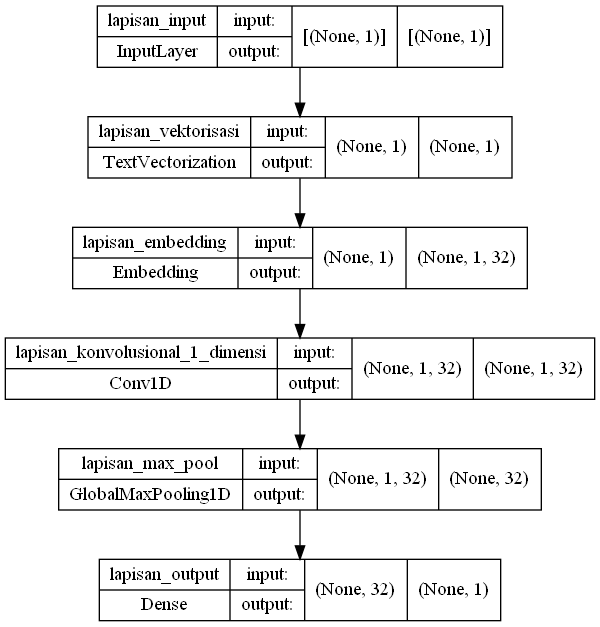

In [62]:
# Plot model_1
plot_model(model_1, show_shapes=True)

### Eksplorasi Hasil Model 1

Setelah proses *training* pada model_1 yang terhenti di epoch 14 setelah melalui beberapa kali reduksi *learning_rate* namun dengan *val_accuracy* yang tidak meningkat setelah melalui sejumlah toleransi epoch dari `EarlyStopping` *callbacks*, kita mendapatkan *val_accuracy* terakhir di 99.21%.
Di bagian bawah kita akan melakukan beberapa evaluasi dari hasil *training* model_1:

1. Evaluasi *val_loss* dan *val_accuracy* model_1
2. Memuat model dengan *val_accuracy* terbaik selama *training* model_1 dan lakukan evaluasi
3. Membuat contoh prediksi dengan model terbaik selama *training* model_1
4. Hitung metrik dari model terbaik selama *training* model_1
5. *Plot confusion matrix* dari model terbaik selama *training* model_1
6. Tampilkan *False Negative* dan *False Positive* dari model terbaik selama *training* model_1 dalam dataframe

In [63]:
# Evaluasi model_1
model_1.evaluate(test_kata_dataset)

355/355 [==============================] - 20s 38ms/step - loss: 0.0289 - accuracy: 0.9921


[0.02888941951096058, 0.9920712113380432]

In [66]:
# Membuat probabilitas prodeksi menggunakan model_1
model_1_pred_prob = tf.squeeze(model_1.predict(test_kata_dataset))
model_1_pred_prob

<tf.Tensor: shape=(11351,), dtype=float32, numpy=
array([9.8689961e-01, 1.5283754e-03, 9.9962139e-01, ..., 1.1869609e-05,
       7.7320910e-06, 4.8428519e-05], dtype=float32)>

In [67]:
# Membuat prediksi untuk model_1
model_1_pred = tf.round(model_1_pred_prob)
model_1_pred

<tf.Tensor: shape=(11351,), dtype=float32, numpy=array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)>

In [68]:
# Menghitung metriks dari model_1
model_1_metrik = hitung_metrik(target=test_target,
                               prediksi=model_1_pred)
model_1_metrik

{'akurasi': 0.9920711831556691,
 'presisi': 0.9920716853479361,
 'recall': 0.9920711831556691,
 'f1-score': 0.9920682214744327}

In [70]:

# ⁡⁣⁢Membuat fungsi untuk plot residual dari model regresi logistik⁡
def residual_plot_logr(test_target, 
                       nama_model,
                       model_akurasi, 
                       probabilitas_prediksi_model, 
                       jumlah_bin=100, 
                       rentang=[0, 1]):
    """
    Fungsi ini akan menciptakan residual plot untuk logistik regresi dari permodelan
    
    Args:
        test_target (np.ndarray): target dari test data dalama bentuk 𝟭D numpy array
        nama_model (str): nama model dalam string untuk ditampilkan di judul plot
        model_akurasi (float): akurasi model
        probabilitas_prediksi_model (np.ndarray): probabilitas prediksi model dalam bentuk 𝟭D numpy array
        jumlah_bin (int): jumlah bin yang akan digunakan untuk plot sepanjang axis x
        rentang (list): rentang yang akan digunakan di axis x
        
    Returns:
        residual_plot (matplotlib.pyplot.scatter): plot residual dari model regresi logistik⁡⁡
    """
    
    # fungsi internal untuk menjumlahkan residu dalam kelompok bin tertentu
    def func(residu):
        y = np.sum(residu)
        return y

    axis_x = [langkah_x/jumlah_bin for langkah_x in range(jumlah_bin+1)]

    residual = test_target - probabilitas_prediksi_model
    bin_residual = binned_statistic(residual, residual, statistic=func, bins=jumlah_bin+1, range=rentang)[0]
    plt.scatter(axis_x, bin_residual, c='r')
    plt.title(f'Residual Regresi Logistik\n{nama_model}\nAkurasi: {model_akurasi:.2%}',
              fontsize=14)
    plt.xlabel('Target Label dalam Bin')
    plt.ylabel('Residual')
    plt.figure(facecolor='w')

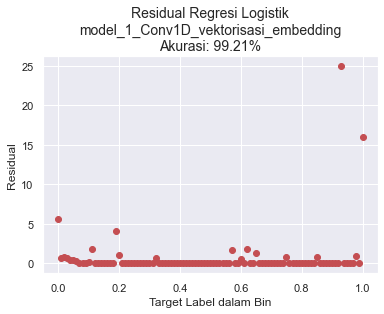

<Figure size 432x288 with 0 Axes>

In [71]:
# Plot residual dari model 1
residual_plot_logr(test_target, MODEL[1], model_1_metrik['akurasi'], model_1_pred_prob)
plt.show()

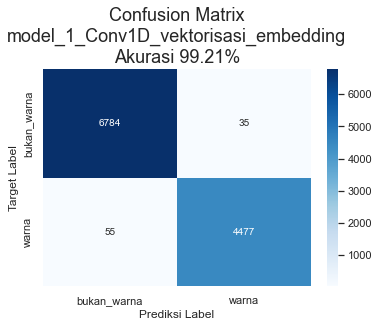

<Figure size 432x288 with 0 Axes>

In [73]:
# Menampilkan confusion matrix dari model_1
plot_conf_matrix(target_label=test_target,
                 prediksi_label=model_1_pred,
                 nama_model=MODEL[1],
                 akurasi=model_1_metrik['akurasi'],
                 label_titik_x=['bukan_warna', 'warna'],
                 label_titik_y=['bukan_warna', 'warna'])
plt.figure(facecolor='w')
plt.show()

In [132]:
# Menampilkan kesalahan prediksi model_1
df_kesalahan_prediksi(label_encoder=label_encoder,
                      test_data=test_data_mnb,
                      prediksi=model_1_pred,
                      probabilitas_prediksi=model_1_pred_prob,
                      order_ulang_header=['brand', 
                                          'kata',
                                          'nama_artikel', 
                                          'urut_kata', 
                                          'total_kata', 
                                          'label'])

|       | brand   | kata        | nama_artikel                                                |   urut_kata |   total_kata | label       | prediksi    | probabilitas   |
|------:|:--------|:------------|:------------------------------------------------------------|------------:|-------------:|:------------|:------------|:---------------|
| 17520 | AGL     | BROWN       | BROWN MOUNTAIN 008 - PEACH                                  |           1 |            4 | bukan_warna | warna       | 99.45%         |
| 21174 | HER     | RED         | HER-HERITAGE-BOSTON RED SOX-(21L)-BAG-US                    |           4 |            8 | bukan_warna | warna       | 99.34%         |
| 56112 | WAR     | RED         | RED BLACK FLAT NON REFLECTIVE-RED/BLACK                     |           1 |            7 | bukan_warna | warna       | 99.34%         |
| 48075 | PTG     | ORANGE      | POLKA ORANGE-ORANGE                                         |           2 |            3 | bukan_warna | warna      

In [75]:
# selesai dengan model 1, bersihkan memori di GPU terkait model_1
del model_1
gc.collect()

10475

## Model 2: Transfer Learning pretrained feature exraction menggunakan Universal Sentence Encoder (USE)

Pada bagian ini kita akan mencoba untuk melakukan training pada data menggunakan lapisan *feature extraction* yang sudah ada dan sudah dilatih pada dataset tertentu. 
Proses embedding secara umum memiliki beberapa kelemahan diantaranya:

1. Kehilangan informasi, dimana dalam kasus kalimat "Produk ini bagus" dan kalimat "Ini" menggunakan rerata vektor memiliki tingkat kemiripan yg cukup tinggi meskipun keduanya merupakan kalimat yang memiliki makna cukup berbeda
2. Tidak memandang urutan, dimana kalimat "Makan ikan menggunakan sendok" dan kalimat "Makan sendok menggunakan ikan" akan memiliki kemiripan vektor 100%

Kita dapat menghindari permasalahan ini misalkan dengan menerapkan *feature engineering* untuk membuat input menjadi semakin kompleks dan menghindari masalah yang mungkin timbul dari proses *embedding*, namun hal ini dapat melibatkan beberapa proses seperti menghilangkan *stop-words*, pembobotan menggunakan TF-IDF, menambahkan *ngrams* untuk mendapatkan posisi kata dalam kalimat, penumpukan lapisan *MaxPooling* dan lain sebagainya.

Universal Sentence Encoder merupakan suatu lapisan yang sudah melakukan hampir kesemua proses ini dalam proses *embedding* input data.

In [76]:
# Mengunduh pretrained USE dari tensorflow hub atau model USE yang sudah didownload
tf_hub_embedding = hub.KerasLayer('colorskim_checkpoint/use.v4/',
                                  trainable=False,
                                  name='lapisan_embedding_USE')

In [83]:
# Melakukan tes pretrained embedding pada contoh kata
kata_acak = random.choice(train_data_mnb['kata'].tolist())
print(f'Kata acak:\n {kata_acak}')
kata_embed_pretrain = tf_hub_embedding([kata_acak])
print(f'\nKata setelah embed dengan USE:\n{kata_embed_pretrain[0]}\n')
print(f'Panjang dari kata setelah embedding: {len(kata_embed_pretrain[0])}')

Kata acak:
 NIKE

Kata setelah embed dengan USE:
[ 0.03551936 -0.01092234 -0.04452999 -0.011615    0.02078822  0.03616779
  0.02028491 -0.04521689 -0.06267793 -0.01205434 -0.06147045 -0.04277659
  0.044472   -0.03846516 -0.01646156  0.04231635 -0.04280001 -0.04259221
  0.02336692 -0.0149713   0.00785487  0.0131372   0.06377136  0.00091608
 -0.01144155 -0.00248365 -0.0456779  -0.046661   -0.01129454 -0.02044706
  0.07824446 -0.02754597  0.00210647  0.07455748  0.03685687  0.04225997
  0.03182033 -0.02679156  0.06342416  0.04529719 -0.06783359 -0.0248361
  0.07103027 -0.00629707  0.00433935  0.05146051 -0.01485019  0.03876241
  0.07278479  0.0009041   0.05664367 -0.06668704  0.0241777   0.07243448
 -0.04070075 -0.06603528  0.06918954 -0.04095845  0.06053145  0.07463565
  0.01343846 -0.02636237  0.0616648   0.05107952  0.02252498  0.02215132
 -0.06586358  0.00607882  0.05185373  0.05264953 -0.07568023 -0.04224531
 -0.00805937 -0.04342831  0.00167232 -0.06503586  0.004361   -0.01371297
 -0

### Membangun dan Menjalankan Training Model 2

In [84]:
# Jika folder dengan path 'colorskim_checkpoint/{model.name}' sudah ada, maka skip fit model 
# untuk menghemat waktu pengembangan dan hanya load model yang sudah ada dalam folder tersebut 
# saja
# Terutama untuk model_2 yang sangat resource intensif, baik data yang didownload dari tfhub.dev
# maupun output model dari training yang cukup besar (~1GB) berbanding model_1 yang hanya menghasilkan
# model dengan ukuran 2MB, maka untuk output model dari model_2 akan disimpan di remote data version
# control dengan modul dvc atau dapat dipindahtangankan secara fisik melalui media penyimpanan
if not os.path.isdir(f'colorskim_checkpoint/{MODEL[2]}'):
        # set random seed
        tf.random.set_seed(RANDOM_STATE)
        
        # Membuat model_2 menggunakan USE
        inputs = Input(shape=[], 
                dtype=tf.string, 
                name='lapisan_input')
        lapisan_embed_pretrained = tf_hub_embedding(inputs)
        x = Conv1D(filters=UKURAN_BATCH, 
                kernel_size=5, 
                padding='same', 
                activation='relu',
                name='lapisan_konvolusional_1_dimensi')(tf.expand_dims(lapisan_embed_pretrained, axis=-1))
        x = GlobalMaxPooling1D(name='lapisan_max_pooling')(x)
        outputs = Dense(units=1, 
                        activation='sigmoid', 
                        name='lapisan_output')(x)
        model_2 = tf.keras.Model(inputs=inputs, 
                                outputs=outputs, 
                                name=MODEL[2])

        # Compile model_2
        model_2.compile(loss=BinaryCrossentropy(),
                        optimizer=Adam(),
                        metrics=['accuracy'])


        # Setup wandb init dan config
        wb.init(project=wandb['proyek'],
                entity=wandb['user'],
                name=model_2.name,
                config={'epochs': EPOCHS,
                        'n_layers': len(model_2.layers)})

        # Fit model_2
        model_2.fit(train_kata_dataset,
                    epochs=EPOCHS,
                    validation_data=test_kata_dataset,
                    callbacks=[wandb_callback(train_kata_dataset),
                               model_checkpoint(model_2.name),
                               reduce_lr_on_plateau(),
                               early_stopping()])
        
        # tutup logging wandb
        wb.finish()
        
        # load model_2
        model_2 = load_model(f'colorskim_checkpoint/{MODEL[2]}')
else:
        # hapus tf_hub_embedding
        del tf_hub_embedding
        gc.collect()
        # load model_2
        model_2 = load_model(f'colorskim_checkpoint/{MODEL[2]}')

In [85]:
# Ringkasan dari model_2
model_2.summary()

Model: "model_2_Conv1D_USE_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lapisan_input (InputLayer)  [(None,)]                 0         
                                                                 
 lapisan_embedding_USE (Kera  (None, 512)              256797824 
 sLayer)                                                         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 512, 1)           0         
                                                                 
 lapisan_konvolusional_1_dim  (None, 512, 32)          192       
 ensi (Conv1D)                                                   
                                                                 
 lapisan_max_pooling (Global  (None, 32)               0         
 MaxPooling1D)                                                   
                                          

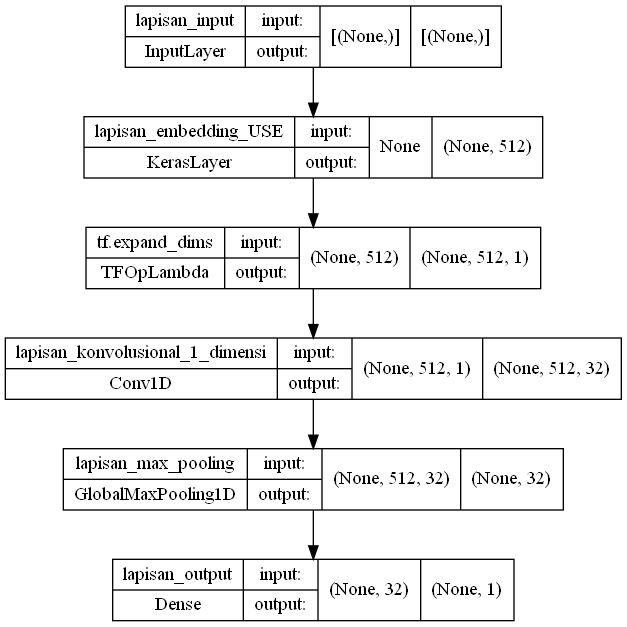

In [86]:
# Plot model_2
plot_model(model_2, show_shapes=True)

### Eksplorasi Hasil Model 2

In [87]:
# Evaluasi model_2
model_2.evaluate(test_kata_dataset)

355/355 [==============================] - 19s 45ms/step - loss: 0.1921 - accuracy: 0.9389


[0.19213275611400604, 0.9388599991798401]

In [88]:
# Membuat probabilitas prediksi model_2
model_2_pred_prob = tf.squeeze(model_2.predict(test_kata_dataset))
model_2_pred_prob

<tf.Tensor: shape=(11351,), dtype=float32, numpy=
array([0.46290663, 0.06519245, 0.9924333 , ..., 0.1533481 , 0.01215318,
       0.0921701 ], dtype=float32)>

In [89]:
# Membuat prediksi dengan model_2
model_2_pred = tf.round(model_2_pred_prob)
model_2_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0.], dtype=float32)>

In [90]:
# Menghitung metriks dari model_2
model_2_metrik = hitung_metrik(target=test_target,
                               prediksi=model_2_pred)
model_2_metrik

{'akurasi': 0.9388600123337151,
 'presisi': 0.9390214154816886,
 'recall': 0.9388600123337151,
 'f1-score': 0.9385958102215999}

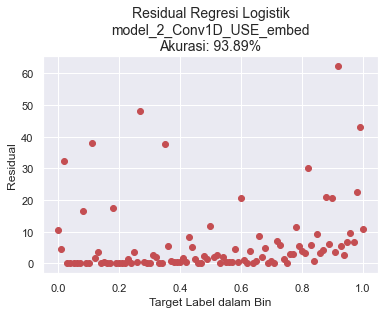

<Figure size 432x288 with 0 Axes>

In [98]:
# Plot residual dari model_2
residual_plot_logr(test_target, MODEL[2], model_2_metrik['akurasi'], model_2_pred_prob)

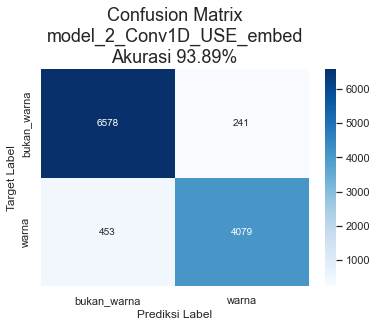

<Figure size 432x288 with 0 Axes>

In [97]:
# Confusion matrix dari model_2
plot_conf_matrix(target_label=test_target,
                 prediksi_label=model_2_pred,
                 nama_model=MODEL[2],
                 akurasi=model_2_metrik['akurasi'],
                 label_titik_x=['bukan_warna', 'warna'],
                 label_titik_y=['bukan_warna', 'warna'])
plt.figure(facecolor='w')
plt.show()

In [133]:
# Menampilkan kesalahan prediksi dalam dataframe
df_kesalahan_prediksi(label_encoder=label_encoder,
                      test_data=test_data_mnb,
                      prediksi=model_2_pred,
                      probabilitas_prediksi=model_2_pred_prob,
                      order_ulang_header=['brand',
                                          'kata',
                                          'nama_artikel',
                                          'urut_kata',
                                          'total_kata',
                                          'label'])

|       | brand   | kata          | nama_artikel                                                                             |   urut_kata |   total_kata | label       | prediksi    | probabilitas   |
|------:|:--------|:--------------|:-----------------------------------------------------------------------------------------|------------:|-------------:|:------------|:------------|:---------------|
| 20530 | CAO     | 700SK         | GA-700SK-1ADR                                                                            |           2 |            3 | bukan_warna | warna       | 97.71%         |
| 56112 | WAR     | RED           | RED BLACK FLAT NON REFLECTIVE-RED/BLACK                                                  |           1 |            7 | bukan_warna | warna       | 97.51%         |
| 21174 | HER     | RED           | HER-HERITAGE-BOSTON RED SOX-(21L)-BAG-US                                                 |           4 |            8 | bukan_warna | warna       | 97.51%      

In [134]:
# selesai dengan model 2, bersihkan memori di GPU terkait model_2
del model_2
gc.collect()

26866

## Model 3: Menggunakan Posisi Kata, Tipe Brand dan Lapisan Embed Custom yang diconcatenate

Pada skenario training ini, kita akan mencoba untuk tidak hanya menggunakan input data kata dan label saja, tetapi juga menambahkan posisi kata dalam kalimat dan juga tipe brand sebagai variabel independen (fitur) yang mungkin dapat menentukan apakah sebuah kata adalah `bukan_warna` atau `warna`.
Pada dasarnya kita akan membuat tumpukan layer yang mempelajari input data per kata dan juga mempelajari posisi dari kata dan juga tipe brand yang kemudian akan ditumpuk (*stack*) menjadi satu lapisan baru.

### Preprocessing untuk `urut_kata` dan `total_kata`?
Sebelum kita melakukan *training* pada variabel `urut_kata` dan juga `total_kata`. Terdapat setidaknya dua opsi untuk menggunakan variabel independen ini:

1. Melakukan pembagian `urut_kata` dan `total_kata` sehingga nilai dari posisi adalah diantara 0 sampai dengan 1, dimana ~0 menunjukkan posisi kata yang berada dekat dengan awal kalimat dan ~1 adalah posisi kata yang berada dengan akhir kalimat. Namun hal ini akan menyebabkan kita akan kehilangan beberapa informasi dari input data, sebagai contoh nilai 0.5 bisa diartikan sebagai kata pertama dalam kalimat yang terdiri dari dua kata (1/2) atau bisa juga berarti kata kelima dalam kalimat yang terdiri dari sepuluh kata (5/10).
2. Melakukan encoding untuk `urut_kata` dan `total_kata` sehingga kita tidak kehilangan informasi dari kedua variabel ini.
3. Menggunakan `urut_kata` dan `total_kata` sebagaimana adanya tanpa melakukan pembagian dan membiarkan model berusaha mempelajari makna dari variabel independen ini.

Pada bagian ini, kita akan mencoba untuk menggunakan opsi kedua.


### USE atau Custom Embedding?
Dikarenakan pada model_2 kita dapat melihat bahwa penggunaan lapisan ekstraktor fitur USE tidak dapat dengan baik memprediksi label kata (hal ini bisa disebabkan oleh beberapa hal, seperti fakta bahwa USE dilatih pada dataset *corpus* bahasa internasional yang mungkin lebih baku), maka kita akan kembali menggunakan lapisan *custom embedding* menggunakan Conv1D atau lapisan LSTM dua arah (*bi-directional LSTM*) seperti pada model_1.

### `urut_kata` dan `total_kata` Embedding

Pada bagian ini kita akan melakukan embedding untuk posisional dari sebuah kata dalam kalimat seperti apa yang direpresentasikan oleh kolom `urut_kata` dan `total_kata`.

In [135]:
# Distribusi jumlah kata dalam artikel - artikel
train_data['urut_kata'].value_counts()

2.0     11981
1.0     11950
5.0      3770
3.0      3638
4.0      3540
6.0      3237
7.0      2568
8.0      1907
9.0      1273
10.0      858
11.0      444
12.0      172
13.0       46
14.0       12
15.0        4
Name: urut_kata, dtype: int64

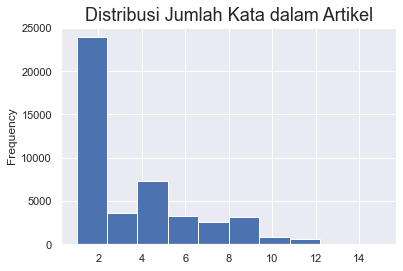

<Figure size 432x288 with 0 Axes>

In [136]:
train_data['urut_kata'].plot.hist()
plt.title('Distribusi Jumlah Kata dalam Artikel', fontsize=18)
plt.figure(facecolor='w')
plt.show()

In [137]:
# Karena panjang kata berbeda - beda, maka kita akan menggunakan one_hot encoding
# dengan depth max
max_kata = int(np.max(train_data['urut_kata']))

# Membuat one_hot tensor untuk kolom 'urut_kata'
train_data_urut_kata_one_hot = tf.one_hot(train_data['urut_kata'].to_numpy(), 
                                          depth=max_kata)
test_data_urut_kata_one_hot = tf.one_hot(test_data['urut_kata'].to_numpy(),
                                         depth=max_kata)
train_data_urut_kata_one_hot[:15], train_data_urut_kata_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.

In [138]:
# Distribusi 'total_kata'
train_data['total_kata'].value_counts()

6.0     6476
5.0     6063
7.0     5918
8.0     5555
9.0     5009
4.0     4497
10.0    4494
11.0    2924
3.0     2452
12.0    1222
13.0     405
2.0      270
14.0      77
15.0      29
1.0        9
Name: total_kata, dtype: int64

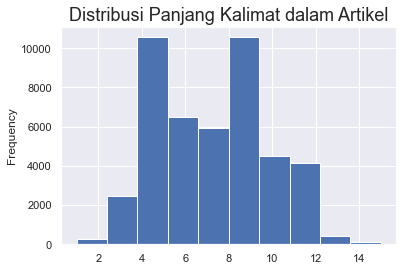

<Figure size 432x288 with 0 Axes>

In [139]:
train_data['total_kata'].plot.hist()
plt.title('Distribusi Panjang Kalimat dalam Artikel', fontsize=18)
plt.figure(facecolor='w')
plt.show()

In [140]:
# Lakukan hal yang sama untuk total_kata
max_kalimat = int(np.max(train_data['total_kata']))

# Membuat one_hot tensor untuk kolom 'total_kata'
train_data_total_kata_one_hot = tf.one_hot(train_data['total_kata'].to_numpy(),
                                           depth=max_kalimat)
test_data_total_kata_one_hot = tf.one_hot(test_data['total_kata'].to_numpy(),
                                          depth=max_kalimat)
train_data_total_kata_one_hot[:15], train_data_total_kata_one_hot.shape


(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.

#### Membuat TensorFlow Dataset, Batching dan Preteching untuk Model 3

In [141]:
# Membuat train dan test dataset (dengan 4 jenis input data)
# Urutan dataset disesuaikan dengan urutan input data pada tf.keras.Model akhir (model_3)
train_fitur_data = from_tensor_slices((train_data.iloc[:, 0],
                                      train_data.iloc[:, 3:].to_numpy(),
                                      train_data_urut_kata_one_hot,
                                      train_data_total_kata_one_hot))
train_target_data = from_tensor_slices(train_target)
train_dataset = zip((train_fitur_data,
                     train_target_data))
train_dataset = train_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)

test_fitur_data = from_tensor_slices((test_data.iloc[:, 0],
                                      test_data.iloc[:, 3:].to_numpy(),
                                      test_data_urut_kata_one_hot,
                                      test_data_total_kata_one_hot))
test_target_data = from_tensor_slices(test_target)
test_dataset = zip((test_fitur_data,
                    test_target_data))
test_dataset = test_dataset.batch(UKURAN_BATCH).prefetch(tf.data.AUTOTUNE)

In [142]:
# Check ukuran dan dimensi dataset
train_dataset, test_dataset

(<BatchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 37), dtype=tf.float64, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

### Membangun dan Menjalankan Training Model 3

1. Membuat model untuk `kata`
2. Membuat model untuk `brand`
3. Membuat model untuk `urut_kata`
4. Membuat model untuk `total_kata`
5. Mengkombinasikan output 1 & 2 menggunakan `tf.keras.layers.Concatenate`
6. Menambahkan Dense dan Dropout layer untuk poin 5
7. Mengkombinasikan output dari poin 3 & 4 menggunakan `tf.keras.layers.Concatenate`
8. Mengkombinasikan output 6 & 7 menggunakan `tf.keras.layers.Concatenate`
9. Membuat lapisan output yang menerima input dari 2 lapisan embedding di poin 8 dan menghasilkan output probabilitas
8. Mengkombinasikan input 1, 2, 3, 4 dan output 9 dalam `tf.keras.Model`

In [143]:
# Jika folder dengan path 'colorskim_checkpoint/{model.name}' sudah ada, maka skip fit model 
# untuk menghemat waktu pengembangan dan hanya load model yang sudah ada dalam folder tersebut 
# saja
if not os.path.isdir(f'colorskim_checkpoint/{MODEL[3]}'):
        # set random seed
        tf.random.set_seed(RANDOM_STATE)
        
        # 1. model kata
        input_kata = Input(shape=(1,), dtype=tf.string, name='lapisan_input_kata')
        lapisan_vektorisasi_kata = lapisan_vektorisasi(input_kata)
        lapisan_embedding_kata = lapisan_embedding(lapisan_vektorisasi_kata)
        lapisan_bi_lstm_kata = Bidirectional(LSTM(units=UKURAN_BATCH), 
                                        name='lapisan_bidirectional_lstm_kata')(lapisan_embedding_kata)
        # ubah bi_lstm menjadi Conv1D dengan GlobalMaxPooling
        # lapisan_Conv1D = Conv1D(filters=UKURAN_BATCH,
        #                         kernel_size=5,
        #                         padding='same',
        #                         activation='relu',
        #                         name='lapisan_konvolusional_1D')(lapisan_embedding_kata)
        # lapisan_max_pooling = GlobalMaxPooling1D(name='lapisan_max_pooling')(lapisan_Conv1D)
        model_kata = Model(input_kata,
                        lapisan_bi_lstm_kata,
                        name='model_kata')

        # 2. model brand
        input_brand = Input(shape=(train_data.iloc[:, 3:].shape[1],), 
                        dtype=tf.float32,
                        name='lapisan_input_brand')
        x = Dense(units=UKURAN_BATCH, 
                activation='relu',
                name='lapisan_dense_rectified_linear_unit_brand')(input_brand)
        model_brand = Model(input_brand,
                        x,
                        name='model_brand')

        # 3. model urut_kata
        input_urut_kata = Input(shape=(max_kata,),
                                dtype=tf.float32,
                                name='lapisan_input_urut_kata')
        x = Dense(units=UKURAN_BATCH,
                activation='relu',
                name='lapisan_dense_rectified_linear_unit_urut_kata')(input_urut_kata)
        model_urut_kata = Model(input_urut_kata,
                                x,
                                name='model_urut_kata')

        # 4. model total_kata
        input_total_kata = Input(shape=(max_kalimat,),
                                dtype=tf.float32,
                                name='lapisan_input_total_kata')
        x = Dense(units=UKURAN_BATCH,
                activation='relu',
                name='lapisan_dense_rectified_linear_unit_total_kata')(input_total_kata)
        model_total_kata = Model(input_total_kata,
                                x,
                                name='model_total_kata')

        # 5. Mengkombinasikan model kata dan brand
        kombinasi_kata_brand = Concatenate(name='lapisan_kombinasi_kata_brand')([model_kata.output, 
                                                                                model_brand.output])

        # 6. Menambahkan lapisan dense dan dropout dari output kombinasi kata dan brand
        z = Dense(256, 
                activation='relu',
                name='lapisan_dense_kombinasi_kata_brand')(kombinasi_kata_brand)
        z = Dropout(0.5)(z)

        # 7. Mengkombinasikan model 3 dan 4
        kombinasi_urut_total_kata = Concatenate(name='lapisan_kombinasi_urut_total_kata')([model_urut_kata.output, 
                                                                                        model_total_kata.output])

        # 8. Mengkombinasikan output di poin 6 dengan lapisan_kombinasi_urut_total_kata
        kombinasi_kata_brand_urut_total_kata = Concatenate(name='lapisan_kombinasi_kata_brand_urut_total_kata')([z,
                                                                                                                kombinasi_urut_total_kata])

        # 9. Membuat lapisan output final
        lapisan_output = Dense(units=1,
                        activation='sigmoid',
                        name='lapisan_output_final')(kombinasi_kata_brand_urut_total_kata)

        # 10. Menyatukan semua model dari berbagai input
        model_3 = Model(inputs=[model_kata.input,
                                model_brand.input,
                                model_urut_kata.input,
                                model_total_kata.input],
                        outputs=lapisan_output,
                        name=MODEL[3])

        # Compile model_3
        model_3.compile(loss=BinaryCrossentropy(),
                        optimizer=Adam(),
                        metrics=['accuracy'])

        # Setup wandb init dan config
        wb.init(project=wandb['proyek'],
                entity=wandb['user'],
                name=model_3.name,
                config={'epochs': EPOCHS,
                        'n_layers': len(model_3.layers)})


        # Fit model_3
        model_3.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=test_dataset,
                    callbacks=[wandb_callback(train_dataset),
                               model_checkpoint(model_3.name),
                               reduce_lr_on_plateau(),
                               early_stopping()])
        
        # tutup logging wandb
        wb.finish()
        
        # load model_3
        model_3 = load_model(f'colorskim_checkpoint/{MODEL[3]}')
else:
        # load model_3
        model_3 = load_model(f'colorskim_checkpoint/{MODEL[3]}')

In [144]:
# Ringkasan dari model_3
model_3.summary()

Model: "model_3_quadbrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lapisan_input_kata (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 lapisan_vektorisasi (TextVecto  (None, 1)           0           ['lapisan_input_kata[0][0]']     
 rization)                                                                                        
                                                                                                  
 lapisan_embedding (Embedding)  (None, 1, 32)        92992       ['lapisan_vektorisasi[0][0]']    
                                                                         

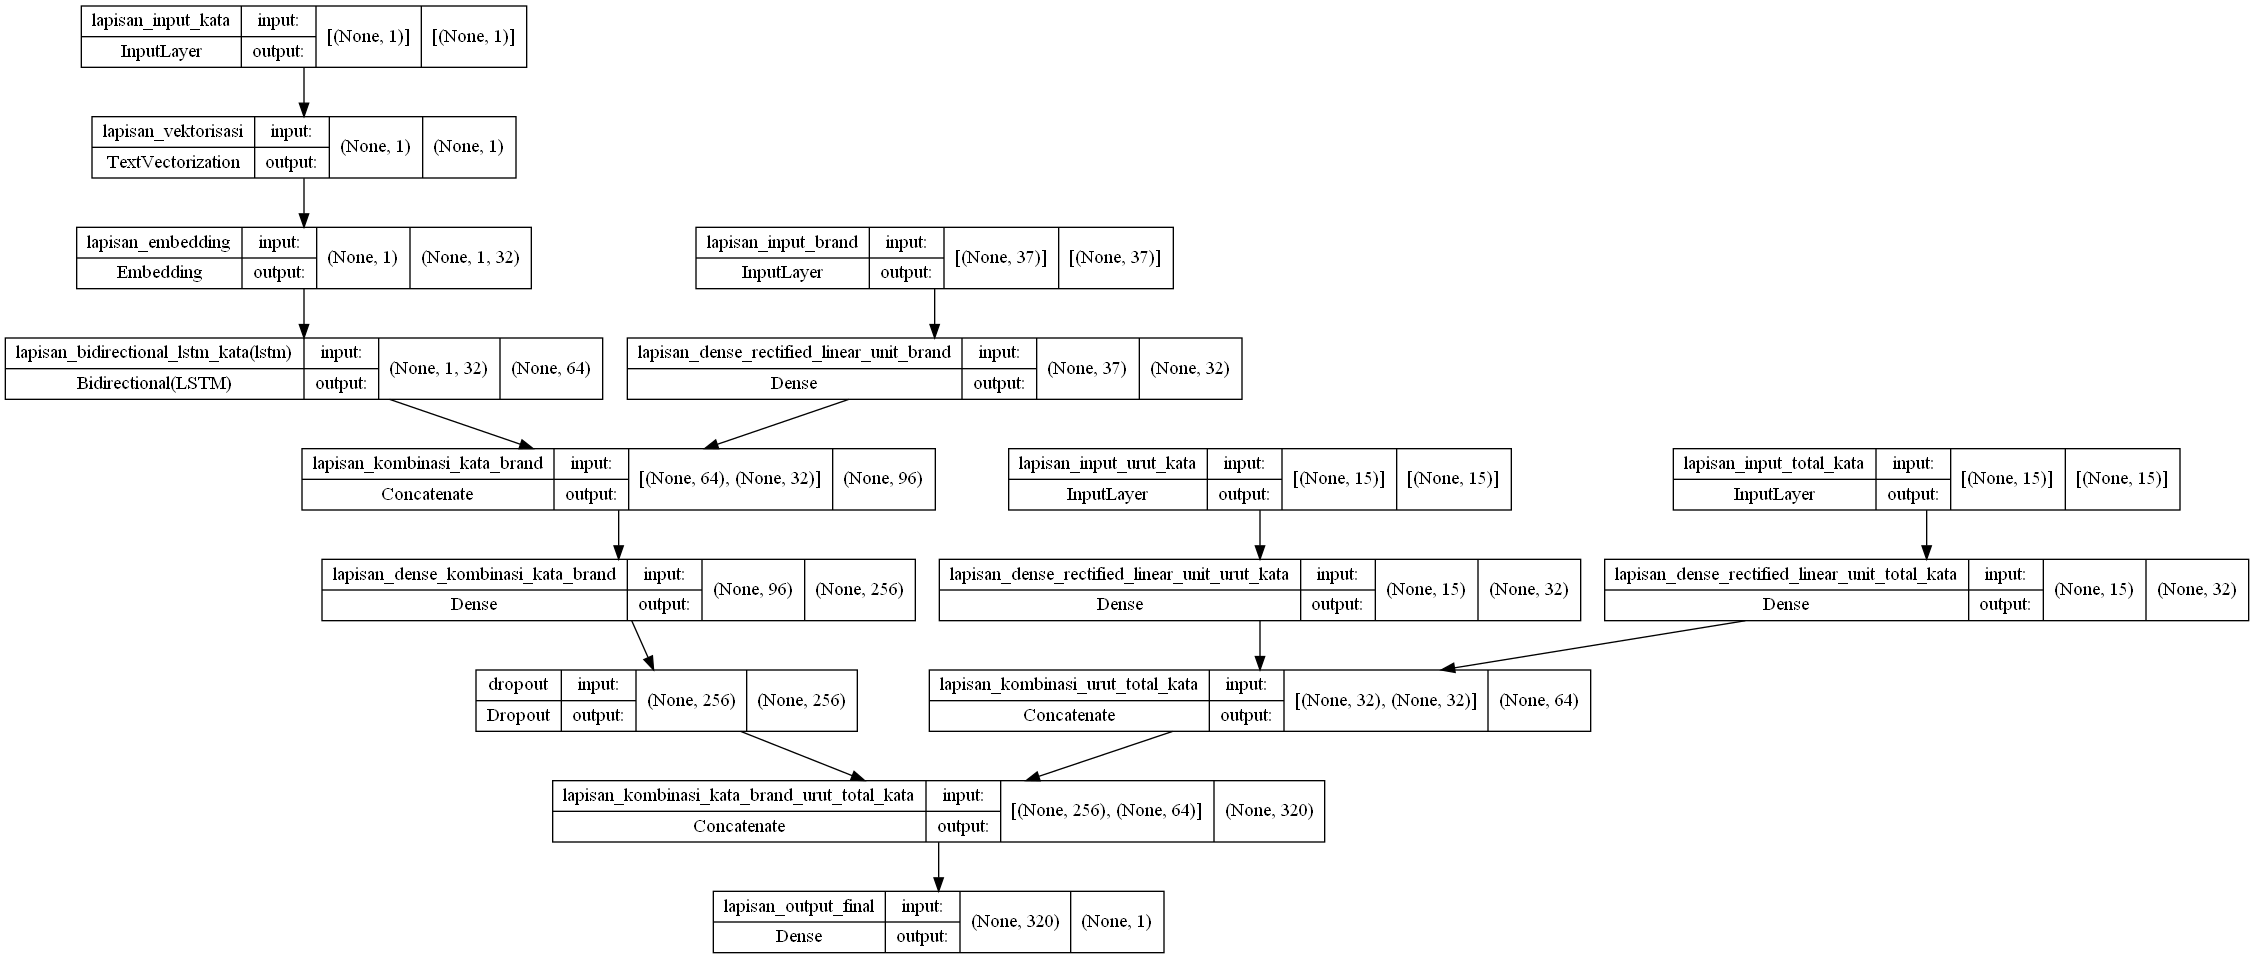

In [145]:
# plot struktur model_3
plot_model(model_3, show_shapes=True)

### Eksplorasi Hasil Model 3

In [146]:
# Evaluasi model_3
model_3.evaluate(test_dataset)

355/355 [==============================] - 40s 98ms/step - loss: 0.0214 - accuracy: 0.9944


[0.021449144929647446, 0.9944498538970947]

In [147]:
# Prediksi probabilitas model_3
model_3_pred_prob = tf.squeeze(model_3.predict(test_dataset))
model_3_pred_prob

<tf.Tensor: shape=(11351,), dtype=float32, numpy=
array([9.9962115e-01, 5.4790482e-05, 9.9976093e-01, ..., 2.4132943e-08,
       3.0743347e-08, 3.4280158e-05], dtype=float32)>

In [148]:
# Membuat prediksi model_3
model_3_pred = tf.round(tf.round(model_3_pred_prob))
model_3_pred

<tf.Tensor: shape=(11351,), dtype=float32, numpy=array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)>

In [149]:
# Metriks skor model_3
model_3_metrik = hitung_metrik(target=test_target,
                               prediksi=model_3_pred)
model_3_metrik

{'akurasi': 0.9944498282089683,
 'presisi': 0.9944503482062841,
 'recall': 0.9944498282089683,
 'f1-score': 0.9944482769856459}

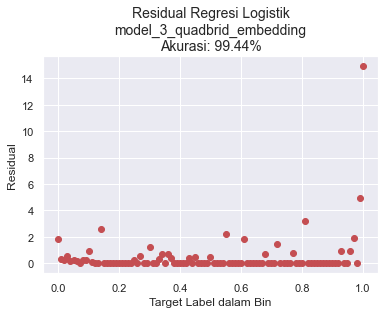

<Figure size 432x288 with 0 Axes>

In [150]:
# Plot residual model_3
residual_plot_logr(test_target=test_target,
                   nama_model=MODEL[3],
                   model_akurasi=model_3_metrik['akurasi'],
                   probabilitas_prediksi_model=tf.squeeze(model_3_pred_prob))

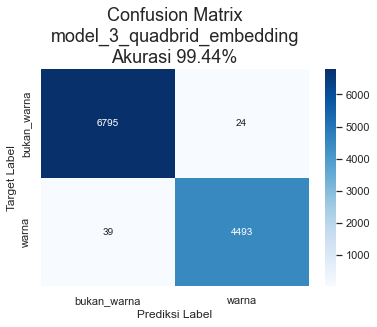

<Figure size 432x288 with 0 Axes>

In [151]:
# Plot confusion matrix
plot_conf_matrix(target_label=test_target,
                 prediksi_label=model_3_pred,
                 nama_model=MODEL[3],
                 akurasi=model_3_metrik['akurasi'],
                 label_titik_x=['bukan_warna', 'warna'],
                 label_titik_y=['bukan_warna', 'warna'])
plt.figure(facecolor='w')
plt.show()

In [152]:
# Dataframe kesalahan prediksi model_3
df_kesalahan_prediksi(label_encoder=label_encoder,
                      test_data=test_data_mnb,
                      prediksi=model_3_pred,
                      probabilitas_prediksi=model_3_pred_prob,
                      order_ulang_header=['brand',
                                          'kata',
                                          'nama_artikel',
                                          'urut_kata',
                                          'total_kata',
                                          'label'])

|       | brand   | kata        | nama_artikel                                               |   urut_kata |   total_kata | label       | prediksi    | probabilitas   |
|------:|:--------|:------------|:-----------------------------------------------------------|------------:|-------------:|:------------|:------------|:---------------|
| 21091 | HER     | 600D        | POP QUIZ-600D POLY NAVY/ZIP                                |           3 |            6 | bukan_warna | warna       | 99.94%         |
| 21174 | HER     | RED         | HER-HERITAGE-BOSTON RED SOX-(21L)-BAG-US                   |           4 |            8 | bukan_warna | warna       | 99.77%         |
| 16288 | ADI     | BLK         | CLR BLK CRW 2PP-BLACK                                      |           2 |            5 | bukan_warna | warna       | 99.4%          |
| 17198 | AGL     | YELLOW      | ESAGLXY YELLOW CRICKET LIGHTER -YELLOW                     |           2 |            5 | bukan_warna | warna       | 97.

In [153]:
# selesai dengan model 3, bersihkan memori di GPU terkait model_3
del model_3
gc.collect()

157980

In [154]:
tf.config.experimental.get_memory_info('GPU:0')

{'current': 25028096, 'peak': 1074304768}

In [155]:
# Membuat fungsi untuk mengambil bobot masing - masing kata dalam neuron model dengan lapisan embedding
def get_bobot_kata(model_list,
                   lapisan_vektorisasi=lapisan_vektorisasi):
    """
    Fungsi ini akan menerima list model dengan lapisan embedding dan menghasilkan file
    vectors_{model.name}.tsv serta file metadata.tsv untuk diproyeksikan
    dalam bidang 3D tensorboard atau projector.tensorflow.org
    
    Args:
        model_list (list): List model yang akan diekstrak bobot neuronnya dan dipergunakan sebagai input di bidang 3D
        lapisan_vektorisasi (tf.keras.layers.TextVectorization): Lapisan text vektorisasi yang akan diambil vocabularynya untuk file metadata.tsv
    """
    kata_dalam_vektorizer = lapisan_vektorisasi.get_vocabulary()
    
    for model in model_list:
        model = load_model(f'colorskim_checkpoint/{model}')
        bobot_kata_embed = model.get_layer('lapisan_embedding').get_weights()[0]
        file_vektor = io.open(f'vectors_{model.name}.tsv', 'w', encoding='utf-8')
        for indeks, _ in enumerate(kata_dalam_vektorizer):
            if indeks == 0:
                continue
            vektor = bobot_kata_embed[indeks]
            file_vektor.write('\t'.join([str(x) for x in vektor]) + '\n')
        file_vektor.close()
        del model
        gc.collect()
    
    file_metadata = io.open(f'metadata.tsv', 'w', encoding='utf-8')
    for kata in kata_dalam_vektorizer:
        file_metadata.write(kata + '\n')
    file_metadata.close()         

In [156]:
# Mengekstrak bobot masing - masing kata dalam neuron dengan model embedding
get_bobot_kata([MODEL[1], MODEL[3]], lapisan_vektorisasi)

## Perbandingan Kinerja dari setiap Model

Dari kesemua model yang sudah kita lakukan training, dapat disimpulkan bahwa:

1. Model 0 dan Model 1 memiliki tingkat akurasi yang cukup tinggi dan nilainya hampir serupa, meskipun model ini cukup sederhana.
2. Model 2 memiliki tingkat akurasi yang paling buruk dibandingkan semua model lainnya. Hal ini bisa dikarenakan banyak inkonsistensi dan typo dalam penulisan nama_artikel yang ada pada data dan *universal sentence encoder* sebagai sebuah lapisan ekstraktor fitur yang sudah ditrain menggunakan corpus (internasional) yang baku mungkin mengalami kesulitan dalam mengekstrak fitur dari data.
3. Model 3 merupakan model dengan tingkat akurasi yang paling tinggi diantara kesemua model. Hal ini mungkin dikarenakan kita menambahkan variabel posisi kata dalam kalimat sebagai salah satu variabel independen yang mempengaruhi output dari variabel dependen label `bukan_warna` atau `warna`.

Laporan log untuk ColorSkim dapat diakses di [*Weights & Biases - ColorSkim*](https://wandb.ai/jpao/ColorSkim?workspace=user-jpao)

**Accuracy**

![accuracy_wandb](images/model_accuracy.png)

**Loss**

![loss_wandb](images/model_loss.png)

**Logs**

![performance_wandb](images/model_performance.png)

In [157]:
# Mengkombinasikan hasil model ke dalam dataframe
hasil_semua_model = pd.DataFrame({"model_0_multinomial_naive_bayes": model_0_metrik,
                                  "model_1_Conv1D_vektorisasi_embedding": model_1_metrik,
                                  "model_2_Conv1D_USE_embed": model_2_metrik,
                                  "model_3_quadbrid_embedding": model_3_metrik})
hasil_semua_model = hasil_semua_model.transpose()
print(hasil_semua_model.to_markdown())

|                                      |   akurasi |   presisi |   recall |   f1-score |
|:-------------------------------------|----------:|----------:|---------:|-----------:|
| model_0_multinomial_naive_bayes      |  0.992159 |  0.99216  | 0.992159 |   0.992156 |
| model_1_Conv1D_vektorisasi_embedding |  0.992071 |  0.992072 | 0.992071 |   0.992068 |
| model_2_Conv1D_USE_embed             |  0.93886  |  0.939021 | 0.93886  |   0.938596 |
| model_3_quadbrid_embedding           |  0.99445  |  0.99445  | 0.99445  |   0.994448 |


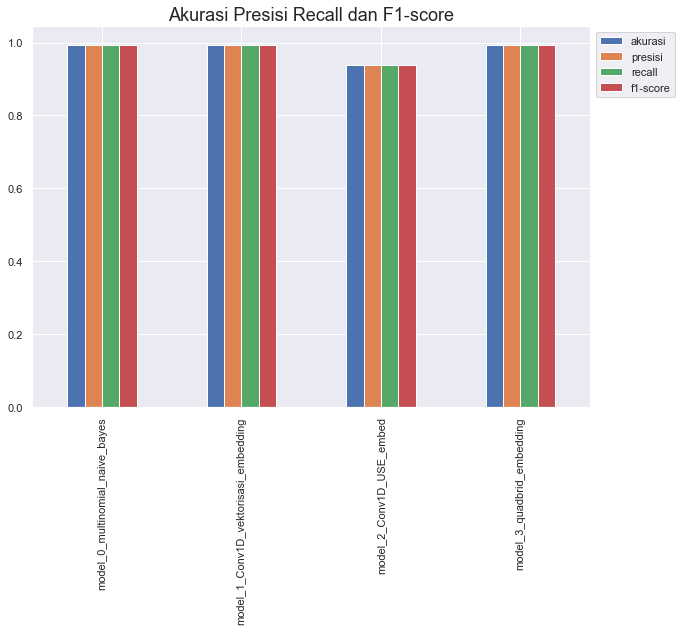

<Figure size 432x288 with 0 Axes>

In [159]:
# Plot dan perbandingan semua hasil model
hasil_semua_model.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))
plt.title('Akurasi Presisi Recall dan F1-score', fontsize=18)
plt.figure(facecolor='w')
plt.show()

Dari ringkasan di atas kita dapat melihat bahwa model_3 unggul di semua metrik dibandingkan dengan model lainnya.

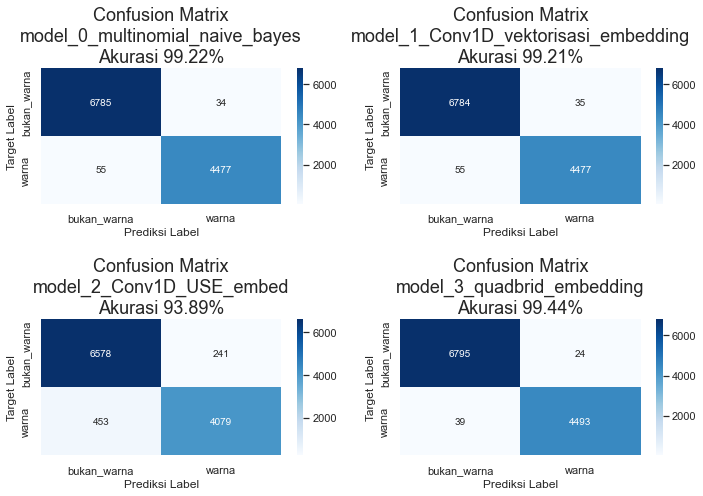

<Figure size 432x288 with 0 Axes>

In [160]:
# Plot confusion matrix semua model
dua_kolom = int(len(MODEL)/2)
fig, axs = plt.subplots(2, dua_kolom, figsize=(10, 7))
for indeks, model in enumerate(MODEL):
    switcher = {
        0: [model_0_pred, model_0_metrik],
        1: [model_1_pred, model_1_metrik],
        2: [model_2_pred, model_2_metrik],
        3: [model_3_pred, model_3_metrik]
    }
    model_pred = switcher.get(indeks)[0]
    model_metrik = switcher.get(indeks)[1]
    axs[indeks if indeks <= 1 else indeks - 2] = plt.subplot(2, 
                                                             dua_kolom, 
                                                             indeks + 1)
    plot_conf_matrix(target_label=test_target_mnb,
                     prediksi_label=model_pred,
                     nama_model=MODEL[indeks],
                     akurasi=model_metrik['akurasi'],
                     label_titik_x=['bukan_warna', 'warna'],
                     label_titik_y=['bukan_warna', 'warna'])
fig.tight_layout(h_pad=2, w_pad=2)
plt.figure(facecolor='w')
plt.show()

Pada *confusion matrix* di atas kita dapat melihat juga bahwa pada model terbaik (model_3), pengujian model terhadap test_data menghasilkan

* 6,795 prediksi `bukan_warna` yang tepat
* 4,493 prediksi `warna` yang tepat
* 39 prediksi `bukan_warna` yang seharusnya adalah `warna`
* 24 prediksi `warna` yang seharusnya adalah `bukan_warna`

Proyeksi kata - kata dalam proses training ke dalam bidang 3 dimensi dapat dilihat di [TensorFlow Projector ColorSkim](http://projector.tensorflow.org/?config=https://gist.githubusercontent.com/johanesPao/4d32ee11e8610a7fc063009e76b08eea/raw/cd227e53ed26694fc050d427083566576ebfa481/template_projector_config.json). Proyeksi kata ke dalam bidang 3 dimensi ini menggunakan model_3 sebagai model dengan tingkat akurasi paling tinggi. Posisi kata dalam bidang 3 dimensi adalah setelah pembobotan dalam training model_3.

*Embedding dalam 3 Dimensi*

![dot_3d](images/dot_3d.png)

*Embedding `white` dalam 3 Dimensi*

![white_3d](images/white_3d.png)

*Embedding `black` dalam 3 Dimensi*

![black_3d](images/black_3d.png)

*Embedding `adidas` dalam 3 Dimensi*

![adidas_3d](images/adidas_3d.png)

*Embedding kata dalam 3 Dimensi*

![kata_3d](images/kata_3d.png)



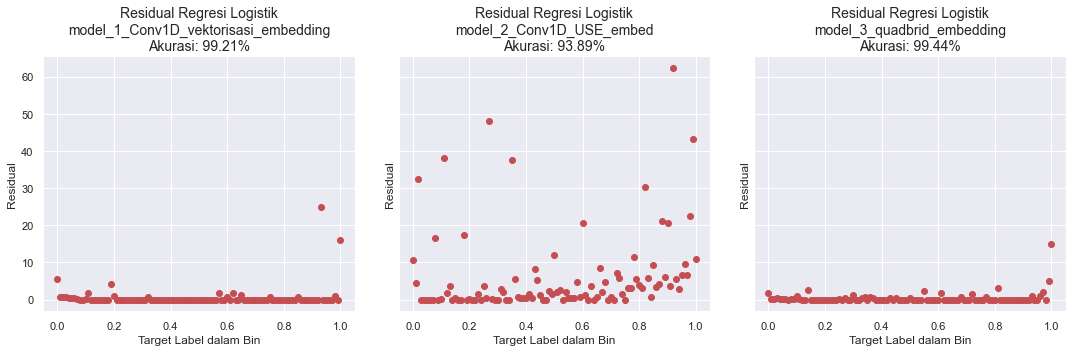

In [96]:
# Plot nilai residual dari model (kecuali untuk model_0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for indeks, model in enumerate(MODEL[1:]):
    switcher = {
        0: [model_1_metrik, model_1_pred_prob],
        1: [model_2_metrik, model_2_pred_prob],
        2: [model_3_metrik, model_3_pred_prob]
    }
    model_metrik = switcher.get(indeks)[0]
    model_pred_prob = switcher.get(indeks)[1]
    axs[indeks] = plt.subplot(1, len(MODEL[1:]), indeks + 1)
    residual_plot_logr(test_target,
                       MODEL[indeks + 1],
                       model_metrik['akurasi'],
                       model_pred_prob)
plt.tight_layout(h_pad=3, w_pad=3)
plt.figure(facecolor='w')
plt.show()

Sama seperti metrik - metrik lainnya dan semua perangkat evaluasi, pada grafik di atas kita dapat melihat bahwa model_3 memiliki residual yang paling minimum (sama dengan akurasi yang tinggi) untuk prediksinya, dimana kita masih dapat melihat sebagian besar residu pada model_3 masih berat di label `warna` dimana model memprediksi `bukan_warna`.